In [1]:
import json
import datetime
import pytz
from tzwhere import tzwhere
tzwhere_ = tzwhere.tzwhere()
import pandas as pd

## Things i want to save:
* timestamp
* geo location
* retweet yes/no
    * retweeted from whom?
* reply yes/no 
    * replied to whom?
* tweet text
* has url?
* has media attached?
* has hashtag attached?

In [2]:
def check_hashtag(single_tweet):
    '''check whether tweet has any hashtags'''
    return 'hashtags' in single_tweet['entities'].keys()

def check_media(single_tweet):
    '''check whether tweet has any media attached'''
    return 'media' in single_tweet['entities'].keys()

def check_url(single_tweet):
    '''check whether tweet has any urls attached'''
    return 'urls' in single_tweet['entities'].keys()

def check_retweet(single_tweet):
    '''
    check whether tweet is a RT. If yes:
    return name & user name of the RT'd user.
    otherwise just return nones
    '''
    if 'retweeted_status' in single_tweet.keys():
        return (single_tweet['retweeted_status']['user']['screen_name'],
                single_tweet['retweeted_status']['user']['name'])
    else:
        return (None,None)
    
def check_coordinates(single_tweet):
    '''
    check whether tweet has coordinates attached.
    if yes return the coordinates
    otherwise just return nones
    '''
    if 'coordinates' in single_tweet['geo'].keys():
        return (single_tweet['geo']['coordinates'][0],
                single_tweet['geo']['coordinates'][1])
    else:
        return (None,None)

def check_reply_to(single_tweet):
    '''
    check whether tweet is a reply. If yes:
    return name & user name of the user that's replied to.
    otherwise just return nones
    '''
    if 'in_reply_to_screen_name' in single_tweet.keys():
        name = None
        for user in single_tweet['entities']['user_mentions']:
            if user['screen_name'] == single_tweet['in_reply_to_screen_name']:
                name = user['name']
                break
        return (single_tweet['in_reply_to_screen_name'],name)
    else:
        return (None,None)

def convert_time(coordinates,time_utc):
    '''
    Does this tweet have a geo location? if yes 
    we can easily convert the UTC timestamp to true local time!
    otherwise return nones
    '''
    if coordinates[0] and coordinates[1]:
        timezone_str = tzwhere_.tzNameAt(coordinates[0],coordinates[1])
        if timezone_str:
            timezone = pytz.timezone(timezone_str)
            time_obj_local = datetime.datetime.astimezone(time_utc,timezone)
            return time_obj_local
    
def create_dataframe(tweets):
    '''
    create a pandas dataframe from our tweet jsons
    '''
    
    # initalize empty lists
    utc_time = []
    longitude = []
    latitude = []
    local_time = []
    hashtag = []
    media = []
    url = []
    retweet_user_name = []
    retweet_name = []
    reply_user_name = []
    reply_name = []
    text = []
    # iterate over all tweets and extract data
    for single_tweet in tweets:
        utc_time.append(datetime.datetime.strptime(single_tweet['created_at'],'%Y-%m-%d %H:%M:%S %z'))
        coordinates = check_coordinates(single_tweet)
        latitude.append(coordinates[0])
        longitude.append(coordinates[1])
        local_time.append(convert_time(coordinates,datetime.datetime.strptime(single_tweet['created_at'],'%Y-%m-%d %H:%M:%S %z')))
        hashtag.append(check_hashtag(single_tweet))
        media.append(check_media(single_tweet))
        url.append(check_url(single_tweet))
        retweet = check_retweet(single_tweet)
        retweet_user_name.append(retweet[0])
        retweet_name.append(retweet[1])
        reply = check_reply_to(single_tweet)
        reply_user_name.append(reply[0])
        reply_name.append(reply[1])
        text.append(single_tweet['text'])
    # convert the whole shebang into a pandas dataframe
    dataframe = pd.DataFrame(data= {
                    'utc_time' : utc_time,
                    'local_time' : local_time,
                    'latitude' : latitude,
                    'longitude' : longitude,
                    'hashtag' : hashtag,
                    'media' : media,
                    'url' : url,
                    'retweet_user_name' : retweet_user_name,
                    'retweet_name' : retweet_name,
                    'reply_user_name' : reply_user_name,
                    'reply_name' : reply_name,
                    'text' : text
    })
    return dataframe

def read_file_index(index_file):
    with open(index_file) as f:    
        d = f.readlines()[1:]
        d = "".join(d)
        d = "[{" + d
        files = json.loads(d)
    return files

def read_single_file(fpath):
    with open(fpath) as f:
        d = f.readlines()[1:]
        d = "".join(d)
        tweets = json.loads(d)
    return tweets

def read_files(file_list,base_path):
    data_frames = []
    for single_file in file_list:
        tweets = read_single_file(base_path + '/' + single_file['file_name'])
        df_tweets = create_dataframe(tweets)
        data_frames.append(df_tweets)
    return data_frames

In [3]:
file_index = read_file_index('twitter_archive/data/js/tweet_index.js')
dataframes = read_files(file_index,'twitter_archive')
dataframe = pd.concat(dataframes)
dataframe.sort_values('utc_time',ascending=False)

,hashtag,latitude,local_time,longitude,media,reply_name,reply_user_name,retweet_name,retweet_user_name,text,url,utc_time
0,True,NaN,None,NaN,True,None,None,Joseph Lewnard,jLewnard,RT @jLewnard: Randomization in the time of Pet...,True,2017-11-21 20:28:45+00:00
1,True,NaN,None,NaN,True,None,None,None,None,You are on openSNP and Open Humans? You can no...,True,2017-11-21 20:12:06+00:00
2,True,NaN,None,NaN,True,None,None,OBF News,obf_news,RT @obf_news: The OBF isn’t doing enough in pu...,True,2017-11-21 17:10:51+00:00
3,True,37.8633,2017-11-21 00:43:04-08:00,-122.273,True,Effy Vayena,EffyVayena,None,None,@EffyVayena @UlrichGenick Also: why is it Citi...,True,2017-11-21 08:43:04+00:00
4,True,NaN,None,NaN,True,None,None,Athina Tzovara,aath0,RT @aath0: Don't miss the chance to apply for ...,True,2017-11-21 08:22:55+00:00
5,True,NaN,None,NaN,True,None,None,Pwn ██ ██ ███ 1.4(C) - Declassified in Part,pwnallthethings,RT @pwnallthethings: How to evaluate blockchai...,True,2017-11-20 22:15:57+00:00
6,True,NaN,None,NaN,True,None,None,None,None,"«Helix is unlikely to do major harm, but it’s ...",True,2017-11-20 22:11:31+00:00
7,True,NaN,None,NaN,True,None,None,Terry McGlynn,hormiga,RT @hormiga: @summeranne @easternblot Too real...,True,2017-11-20 21:27:20+00:00
8,True,NaN,None,NaN,True,None,None,Sujai Kumar,sujaik,RT @sujaik: I'm glad the guys in the video are...,True,2017-11-20 21:21:36+00:00
9,True,NaN,None,NaN,True,None,None,Dan Holden,danrholden,"RT @danrholden: ATTENTION, ATTENTION! This is ...",True,2017-11-20 21:04:33+00:00


In [ ]:
dataframe

In [4]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

(array([  929.,   564.,   187.,    57.,    12.,    19.,    51.,   225.,
          643.,   830.,  1028.,  1080.,   941.,   950.,   921.,   849.,
          837.,   839.,   810.,   907.,   904.,   935.,   942.,  1128.]),
 array([  0.        ,   0.95833333,   1.91666667,   2.875     ,
          3.83333333,   4.79166667,   5.75      ,   6.70833333,
          7.66666667,   8.625     ,   9.58333333,  10.54166667,
         11.5       ,  12.45833333,  13.41666667,  14.375     ,
         15.33333333,  16.29166667,  17.25      ,  18.20833333,
         19.16666667,  20.125     ,  21.08333333,  22.04166667,  23.        ]),
 <a list of 24 Patch objects>)

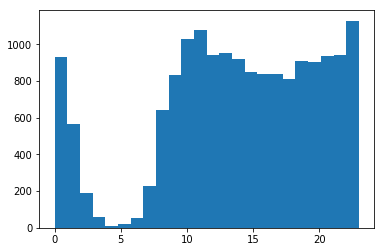

In [5]:
hours = []
for timestamp in list(dataframe[dataframe.local_time.notnull()].local_time.astype(datetime.datetime)):
    hours.append(timestamp.hour)
matplotlib.pyplot.hist(hours,bins=24)

(array([ 2180.,  2324.,  2651.,  2565.,  2517.,  2329.,  2022.]),
 array([ 1.        ,  1.85714286,  2.71428571,  3.57142857,  4.42857143,
         5.28571429,  6.14285714,  7.        ]),
 <a list of 7 Patch objects>)

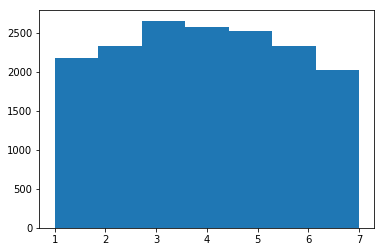

In [6]:
weekday = []
for timestamp in list(dataframe[dataframe.local_time.notnull()].local_time.astype(datetime.datetime)):
    weekday.append(timestamp.isoweekday())
matplotlib.pyplot.hist(weekday,bins=7)